# Imports

In [2]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from datetime import datetime
from dataset_manipulation.dataloaders import DataLoaderFactory 


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/quintana/github/MM_Diffusion/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
torch.manual_seed(0)

In [5]:
data_path = '../data'

In [6]:
dlf = DataLoaderFactory(datadir=data_path, num_workers=1, pin_memory=True)

In [7]:
"""
Choose a modality dataset name from the following 'polymnist_unimodal','cub_image', 'cub_caption'
For polymnist choose the modality nuber in {0,1,2,3,4}.
Then you can modify the parameters below
"""
dataset_name = 'cub_image'#'polymnist_unimodal' #or 'cub_image'#'cub_caption'
dataset_name = 'cub_caption'
modality = 0 if dataset_name== 'polymnist_unimodal' else None

In [35]:
# datasets_names = ['polymnist_unimodal','polymnist_multimodal','cub_caption','cub_image','cub_joint']

# Utils

In [8]:
def plot_training_curves(mean_losses, mean_neg_loglikelihood,  mean_divs):
    epochs = len(mean_losses)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(epochs), mean_losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1, 3, 2)
    plt.plot(range(epochs), mean_neg_loglikelihood, label='Mean neg_loglikelihood')
    plt.xlabel('Epochs')
    plt.ylabel('Mean neg_loglikelihood')
    plt.title('Mean neg_loglikelihood')

    plt.subplot(1, 3, 3)
    plt.plot(range(epochs), mean_divs, label='KL Divergence')
    plt.xlabel('Epochs')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence')

    plt.tight_layout()
    plt.show()

In [9]:
def get_objective(obj):
    if obj == 'elbo':
        from objectives import elbo 
        return elbo
    elif obj == 'iwae':
        from objectives import iwae 
        return iwae
    elif obj ==  'dreg':
        from objectives import  dreg 
        return dreg
    else:
            raise ValueError(f"Dataset '{obj}' is not supported. Choose from 'elbo', 'iwae', 'dreg'.")

In [10]:
def get_model(dataset_name, params):
    if dataset_name == 'cub_caption':
        from models.vae_cub_text import CUB_Sentence
        return CUB_Sentence(params)
    elif dataset_name == 'cub_image':
        from models.vae_cub_image import CUB_Image
        return CUB_Image(params)
    elif dataset_name ==  'polymnist_unimodal':
        from models.vae_polymnist import PM_unimodal
        return PM_unimodal(params)
    else:
            raise ValueError(f"Dataset '{dataset_name}' is not supported. Choose from 'polymnist_unimodal', 'cub_caption', 'cub_image'.")

In [11]:
def plot_generations(generation, n_samples, dataset_name = dataset_name):
    if dataset_name=='cub_caption':
        ohe_txt = plot_sentences_as_tensor(generation.squeeze(0))
        plot_CUB_text(ohe_txt, n_samples)
    else:
        plot_images(generation.squeeze(0), n_samples)

## Text utils

In [12]:
maxSentLen = 32  # max length of any description for birds dataset
minOccur = 3

In [13]:
vocab_file = data_path + '/cub/oc:{}_msl:{}/cub.vocab'.format(minOccur, maxSentLen)

In [14]:
def load_vocab(vocab_file = vocab_file):
        # call dataloader function to create vocab file if it doesn't exist
        # if not os.path.exists(vocab_file):
        #     _, _ = self.getDataLoaders(256)
        with open(vocab_file, 'r') as vocab_file:
            vocab = json.load(vocab_file)
        return vocab['i2w']

In [15]:
i2w = load_vocab()

In [16]:
fn_trun = lambda s: s[:np.where(s == 2)[0][0] + 1] if 2 in s else s

In [17]:
fn_2i = lambda t: t.cpu().numpy().astype(int)

In [18]:
def sent_process(sentences):
        return [fn_trun(fn_2i(s)) for s in sentences]

## Visualization

In [19]:
def plot_images(data, n_samples, modality = 1):
    n_rows =  1
    n_cols = n_samples
    # Set up the subplot grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    
    for i in range(n_cols):
        ax = axes[i] #if n_images > 1 else axes[j]
        img = data[i].detach().cpu().numpy().transpose(1, 2, 0)

        ax.imshow(img)
        ax.axis('off')  # Turn off axis
    
    plt.tight_layout()
    plt.show()

In [20]:
# Helper function to plot captions so to smoothly log on WandB
def plot_text_as_image_tensor(sentences_lists_of_words, pixel_width=64, pixel_height=384):
    imgs = []
    for sentence in sentences_lists_of_words:
        px = 1 / plt.rcParams['figure.dpi']  # pixel in inches
        fig = plt.figure(figsize=(pixel_width * px, pixel_height * px))
        plt.text(
            x=1,
            y=0.5,
            s='{}'.format(
                ' '.join(i + '\n' if (n + 1) % 1 == 0
                         else i for n, i in enumerate([word for word in sentence.split() if word != '<eos>']))),
            fontsize=7,
            verticalalignment='center_baseline',
            horizontalalignment='right'
        )
        plt.axis('off')

        # Draw the canvas and retrieve the image as a NumPy array
        fig.canvas.draw()
        image_np = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_np = image_np.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        # Convert the NumPy array to a PyTorch tensor
        image_tensor = torch.from_numpy(image_np).permute(2, 0, 1).float() / 255  # Normalize to [0, 1]
        imgs.append(image_tensor)
        # Clean up the figure
        plt.close(fig)
    return torch.stack(imgs, dim=0)

In [21]:
def plot_sentences_as_tensor(batched_text_modality):
    """

    Args:
        batched_text_modality: Gets batch of text modality (as it is in input to forward function)

    Returns:
        Tensor with a corresponding plot containing the given text
    """
    sentences_processed = sent_process(batched_text_modality.argmax(-1))
    sentences_worded = [' '.join(i2w[str(word)] for word in sent if i2w[str(word)] != '<pad>') for sent in sentences_processed]
    return plot_text_as_image_tensor(sentences_worded, pixel_width=64, pixel_height=384)

In [22]:
def plot_CUB_text(data, n_samples):
    n_rows =  1
    n_cols = n_samples
    # Set up the subplot grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
    
    for i in range(n_cols):
        ax = axes[i] #if n_images > 1 else axes[j]
        img = data[i].detach().cpu().numpy().transpose(1, 2, 0)

        ax.imshow(img)
        ax.axis('off')  # Turn off axis
    
    plt.tight_layout()
    plt.show()

# Train function

In [23]:
def create_log_dir(epochs, beta, latent_dim, dist, obj='elbo', dataset_name=dataset_name, modality=None):
    if dataset_name == 'polymnist_unimodal':
        dataset_name+='_'+str(modality)
    # Generate a unique directory name
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    log_and_model_dir = f'../runs/{dataset_name}/vae/ep_{epochs}_beta_{beta}_lt_{latent_dim}_dist_{dist}_{obj}_{timestamp}'        
    os.makedirs(log_and_model_dir, exist_ok=True)
    # Use this directory for both TensorBoard logs and saving models
    return log_and_model_dir

In [24]:
def train(model, dataloader, optimizer, epochs, beta, log_path, objective,  log_interval=1, K=1, plot_freq = 5):
    
    model.train()
    
    writer = SummaryWriter(log_path)
    # Lists to store the mean values of metrics per epoch
    mean_losses = []
    mean_neg_loglikelihood= []
    mean_divs = []
    

    for epoch in tqdm(range(epochs)):
        # Lists to store metrics per batch in the current epoch
        batch_losses = []
        batch_neg_loglikelihood= []
        batch_divs = []

        for i, (data,_) in enumerate(train_loader):
            if dataset_name == 'polymnist_unimodal':
                data = data[0]
            data = data.to(device)
            optimizer.zero_grad()
            elbo, neg_logliklihood, div = objective(model, data, beta, K=K)
            loss = - elbo
            loss.backward()
            optimizer.step()
            # Store the metrics for the current batch
            batch_losses.append(loss.item())
            batch_neg_loglikelihood.append(neg_logliklihood.item())
            batch_divs.append(div.item())

        # Compute the mean values for the current epoch and store them
        mean_losses.append(sum(batch_losses) / len(batch_losses))
        mean_neg_loglikelihood.append(sum(batch_neg_loglikelihood) / len(batch_neg_loglikelihood))
        mean_divs.append(sum(batch_divs) / len(batch_divs))
        
        # Log metrics to TensorBoard
        if epoch % log_interval == 0:  # Log every 'log_interval' epochs
            writer.add_scalar('Total Loss/train', mean_losses[-1], epoch)
            writer.add_scalar('Negative LogLikelihood/train', mean_neg_loglikelihood[-1], epoch)
            writer.add_scalar('Div/train', mean_divs[-1], epoch)
       
        if (epoch+1)%plot_freq ==0 or epoch==epochs-1:
                N = 9
                generations = model.generate(N)
                plot_generations(generations, N)
        
        # Optional: print the mean metrics for the current epoch
        # print(f"Epoch {epoch+1}/{epochs}, Loss: {mean_losses[-1]:.4f}, log p(x|z): {mean_log_px_zs[-1]:.4f}, DIV: {mean_divs[-1]:.4f} ")
       # Save the model
        model_save_path = os.path.join(log_path, 'model_state_dict.pt')
        torch.save(model.state_dict(), model_save_path)
    writer.close()
    
    return mean_losses, mean_neg_loglikelihood,  mean_divs


# Model instantiation & training

In [25]:
"""
You can define the model hyper parameters here
"""

class Params:
    def __init__(self, device = device, modality=modality):
        self.priorposterior = 'Normal'
        if dataset_name == 'cub_image':
            self.latent_dim = 16
        elif dataset_name == 'cub_caption':
            self.latent_dim = 48
        elif dataset_name == 'polymnist_unimodal':
            self.latent_dim = 64
        self.modality = modality            
        self.device = device

In [26]:
"""
Training parameters
"""
batch_size = 256
epochs = 10
obj = 'elbo'
objective = get_objective(obj)
beta = 1
K=1
plot_freq = 5
lr = 1e-3

In [27]:
params = Params()

In [28]:
model = get_model(dataset_name, params).to(device)

In [29]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=lr, amsgrad=True)

## Parameters definition

## Train

In [30]:
train_loader, test_loader = dlf.get_dataloader(dataset_name, batch_size, modality=params.modality)

In [31]:
log_path = create_log_dir(epochs, beta, params.latent_dim, params.priorposterior, obj=obj, modality=params.modality)
mean_losses, mean_neg_loglikelihood,  mean_divs = train(model, train_loader, optimizer, epochs, beta, log_path,
          log_interval=1, K=K, objective=objective)
        

  0%|          | 0/10 [01:24<?, ?it/s]


KeyboardInterrupt: 

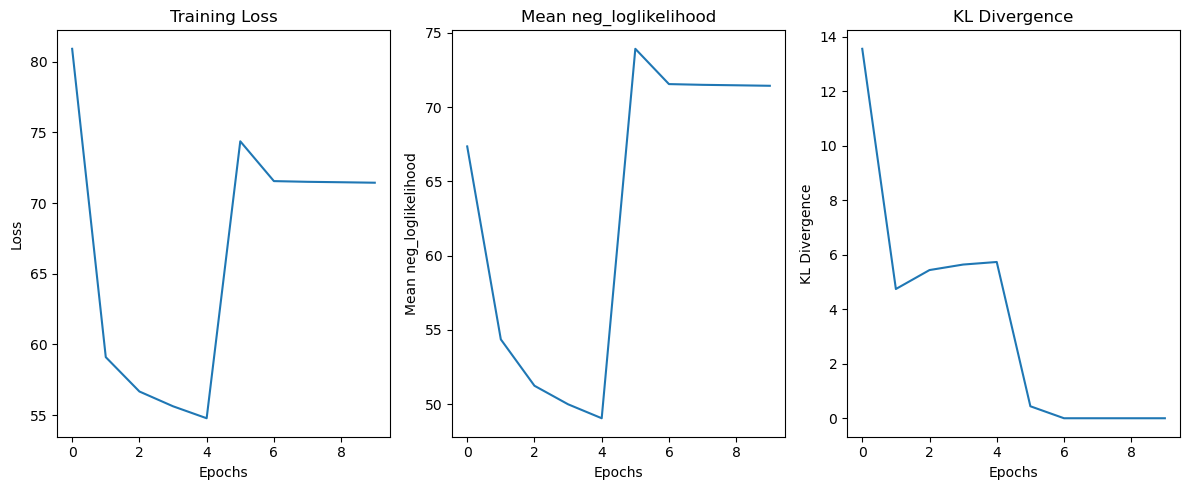

In [60]:
plot_training_curves(mean_losses, mean_neg_loglikelihood,  mean_divs)